# Multi-agent network - collaboration pattern

This notebook is a small experiment of building a multi-agent network using a collaboration pattern in [LangGraph](https://www.langchain.com/langgraph), where we built the network from scratch without preuilt components or `Command`.

In [1]:
import os
from functools import partial
from typing import Annotated, TypedDict

from dotenv import load_dotenv
from langchain_core.messages import (
    AIMessage,
    ToolMessage,
)
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_experimental.utilities import PythonREPL
# from langchain_community.tools import WikipediaQueryRun
# from langchain_community.utilities import WikipediaAPIWrapper

In [2]:
# environmental variables include a TAVILY_API_KEY and a token to use LLM
load_dotenv()

True

## Define tools

The researcher will use a (web) search tool called [Tavily](https://tavily.com/), and the coder has a python REPL tool. You will need a `TAVILY_API_KEY` to use the Tavily tool.

In [3]:
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    title="python_repl",
    description=(
        "A Python shell. Use this to execute python commands. Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out with `print(...)`. "
        "Any charts you display will be visible by the user."
    ),
    func=python_repl.run,
)
tavily_tool = TavilySearchResults(max_results=5)
# wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [4]:
tools = [tavily_tool, repl_tool]

## Define states (a list of messages)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Create tool nodes

In [6]:
researcher_tool_node = ToolNode(tools=[tavily_tool])
coder_tool_node = ToolNode(tools=[repl_tool])

In [7]:
# maybe can use tools_condition for add_conditional_edges
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "tool_calls" in last_message.additional_kwargs and not last_message.invalid_tool_calls:
        # The previus agent is invoking a valid tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

## Define model

In [8]:
llm = ChatOpenAI(
    base_url=os.getenv("OPENAI_API_ENDPOINT"),
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4o",
    temperature=0,
)

## Define agents

In [20]:
def create_agent(llm, role, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful {role}, collaborating with other agents."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools"
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}"
                " Only use tools if you need them. Only use tools listed above."
                " Pass the task to other agents if you cannot make progress.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(role=role, system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [21]:
def agent_node(state, agent, name):
    result = agent.invoke(state["messages"])
    # We convert the agent output into a format that is suitable to append to the global state
    if not isinstance(result, ToolMessage):
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
    }

In [22]:
research_agent = create_agent(
    llm,
    "researcher",
    [tavily_tool],
    system_message="You should provide accurate data for the coder to use. Do not attempt any computations yourself.",
)

In [23]:
coder_agent = create_agent(
    llm,
    "python coder",
    [repl_tool],
    system_message="You are a python coder specialized in computations and charting.",
)

In [24]:
research_node = partial(agent_node, agent=research_agent, name="researcher")
coder_node = partial(agent_node, agent=coder_agent, name="python_coder")

## Create graph

In [25]:
graph_builder = StateGraph(State)

In [26]:
graph_builder.add_node("researcher", research_node)
graph_builder.add_node("python_coder", coder_node)
graph_builder.add_node("researcher_tool", researcher_tool_node)
graph_builder.add_node("coder_tool", coder_tool_node)
graph_builder.add_conditional_edges(
    "researcher",
    router,
    {"continue": "python_coder", "call_tool": "researcher_tool", "end": END},
)
graph_builder.add_conditional_edges(
    "python_coder",
    router,
    {"continue": "researcher", "call_tool": "coder_tool", "end": END},
)
graph_builder.add_edge(
    "researcher_tool",
    "researcher"
)
graph_builder.add_edge(
    "coder_tool",
    "python_coder"
)
graph_builder.set_entry_point("researcher")
graph = graph_builder.compile()

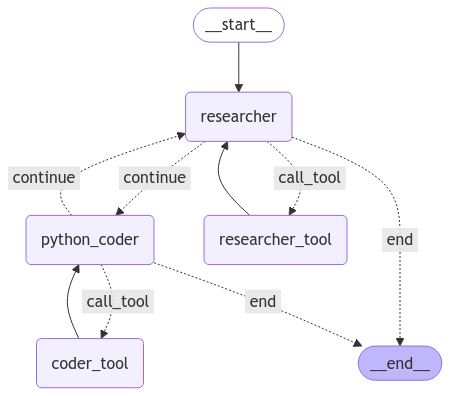

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use cases

With the graph created, let's test it on some problems.

{'researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_StxobBI3q1HujvHoUBja8cZQ', 'function': {'arguments': '{"query":"Hong Kong GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 246, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_82ce25c0d4', 'finish_reason': 'tool_calls', 'logprobs': None}, name='researcher', id='run-650d609a-4ea6-4c7e-a4ab-a97399818382-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Hong Kong GDP past 5 years'}, 'id': 'call_StxobBI3q1HujvHoUBja8cZQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 246, 'output_tokens': 24, 'total_

Python REPL can execute arbitrary code. Use with caution.


{'python_coder': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wuixm21WhHiEZqNMbgKx4wAE', 'function': {'arguments': '{"__arg1":"import matplotlib.pyplot as plt\\n\\n# Data for Hong Kong\'s GDP (in billion USD)\\nyears = [2018, 2019, 2020, 2021, 2022, 2023]\\ngdp = [345, 369, 363, 384, 382, 382.05]\\n\\n# Create the line chart\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp, marker=\'o\', linestyle=\'-\', color=\'b\')\\n\\n# Add labels and title\\nplt.title(\\"Hong Kong\'s GDP (2018-2023)\\", fontsize=16)\\nplt.xlabel(\\"Year\\", fontsize=12)\\nplt.ylabel(\\"GDP (in billion USD)\\", fontsize=12)\\nplt.grid(True)\\n\\n# Show the chart\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 191, 'prompt_tokens': 4708, 'total_tokens': 4899, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_token

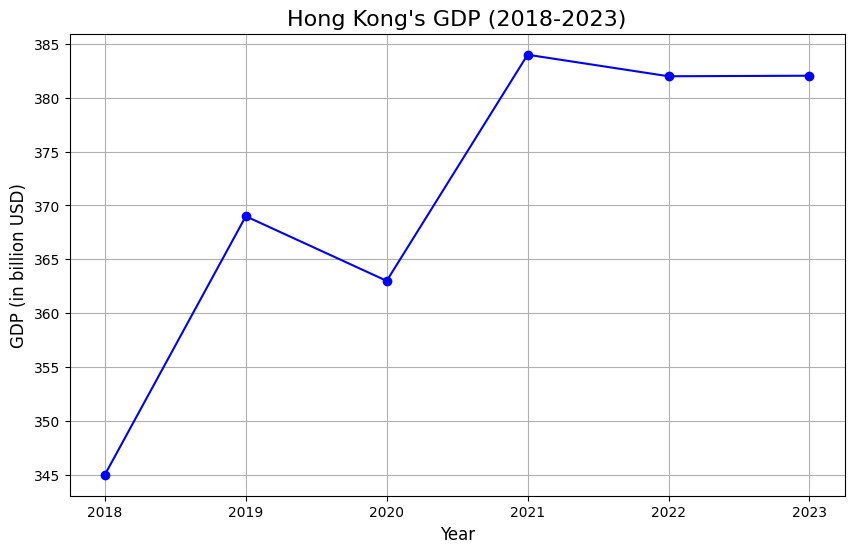

{'coder_tool': {'messages': [ToolMessage(content='', name='python_repl', id='93c87913-ec53-44cc-909e-cbfb559eb4fd', tool_call_id='call_wuixm21WhHiEZqNMbgKx4wAE')]}}
----
{'python_coder': {'messages': [AIMessage(content="The line chart for Hong Kong's GDP from 2018 to 2023 has been successfully created and displayed. \n\nFINAL ANSWER", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 4912, 'total_tokens': 4940, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_82ce25c0d4', 'finish_reason': 'stop', 'logprobs': None}, name='python_coder', id='run-87c428f9-7ef3-4f9f-8c02-280903e95de6-0', usage_metadata={'input_tokens': 4912, 'output_tokens': 28, 'total_tokens': 4940, 'input_token_details': {'audio': 0, 'cache_rea

In [17]:
res1 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get Hong Kong's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 30},
):
    res1.append(s)
    print(s)
    print("----")

In [31]:
for s in res1:
    sender = list(s.keys())[0]
    message = s[sender]["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================== Ai Message ==================================
Name: researcher
Tool Calls:
  tavily_search_results_json (call_StxobBI3q1HujvHoUBja8cZQ)
 Call ID: call_StxobBI3q1HujvHoUBja8cZQ
  Args:
    query: Hong Kong GDP past 5 years
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/statistics/316972/hong-kong-gross-domestic-product/", "content": "Premium Statistic Gross domestic product (GDP) growth in Hong Kong 2001-2028 Premium Statistic GDP share of the financial services industry of Hong Kong 2012-2022 Premium Statistic GDP share of the financial services industry Hong Kong 2012-2022, by category Premium Statistic GDP share of the trading and logistics industry Hong Kong 2012-2022 \"Gross Domestic Product (Gdp) at Current Prices in Hong Kong from 2000 to 2023 with Forecasts until 2029 (in Billion U.S. Dollars and Hong Kong Dollars).\" Statista, Statista Inc., 

In [28]:
res2 = []
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the latest GDP of Hong Kong and Singapore, then calculate their geometric average.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 30},
):
    res2.append(s)
    print(s)
    print("----")

{'researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6zpQ2oXfgYv5z8uDYFg4ZcRo', 'function': {'arguments': '{"query": "latest GDP of Hong Kong 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_4aLTruOa52rQUEAXFcZ78Cvf', 'function': {'arguments': '{"query": "latest GDP of Singapore 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 238, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_82ce25c0d4', 'finish_reason': 'tool_calls', 'logprobs': None}, name='researcher', id='run-742bbf98-63fb-42f3-8261-d10cc6c7fe47-0', tool_calls=[{'name': 'tavily_search_results_json', 'a

In [30]:
for s in res2:
    sender = list(s.keys())[0]
    message = s[sender]["messages"][-1]
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================== Ai Message ==================================
Name: researcher
Tool Calls:
  tavily_search_results_json (call_6zpQ2oXfgYv5z8uDYFg4ZcRo)
 Call ID: call_6zpQ2oXfgYv5z8uDYFg4ZcRo
  Args:
    query: latest GDP of Hong Kong 2023
  tavily_search_results_json (call_4aLTruOa52rQUEAXFcZ78Cvf)
 Call ID: call_4aLTruOa52rQUEAXFcZ78Cvf
  Args:
    query: latest GDP of Singapore 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://tradingeconomics.com/singapore/gdp", "content": "The Gross Domestic Product (GDP) in Singapore was worth 501.43 billion US dollars in 2023, according to official data from the World Bank. The GDP value of Singapore represents 0.48 percent of the world economy. This page provides the latest reported value for - Singapore GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar"}, {"url": "https: